<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Background-subtraction" data-toc-modified-id="Background-subtraction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background subtraction</a></span><ul class="toc-item"><li><span><a href="#vTel" data-toc-modified-id="vTel-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>vTel</a></span></li><li><span><a href="#POA" data-toc-modified-id="POA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POA</a></span></li></ul></li></ul></div>

The .tif files uploaded were previously treated in ImageJ. 

1. Median 3D: X radius = Y radius = Z radius = 2.0
3. Select ROIs: vTel and POA
4. Z Projection SUM: 80 slices

ROIs: 
- ventral telencephalon (vTel)
- preoptic area (POA)

In [4]:
import os
import glob
import cv2 

from scipy import ndimage
from scipy import stats
import scikit_posthocs as sp
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import cm
import seaborn as sns
import ptitprince as pt
from scipy.spatial import distance
import pandas as pd

from PIL import Image
from skimage.external.tifffile import imread
from skimage.external.tifffile import imshow
from skimage.morphology import watershed, disk
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.feature import peak_local_max

import numpy as np
import plotly.graph_objects as go

#%matplotlib inline
import mpld3
mpld3.enable_notebook()

### Loading Data

In [43]:
def load_tif(files):
    group = []
    
    for file in files:
        im_open = Image.open(file)
        im_read = imread(file)    
        im = cv2.normalize(im_read,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U)
        group.append(im)
    
    return group

In [37]:
paths = []

for roi in ['center','diencephalon', 'periphery', 'vtel']:
    for treatment in ['dDMSO','vDMSO','dMTZ','vMTZ']:
        
        path = glob.glob(f'/media/renata/renata_data_2/Figures_Ablation/roi_{roi}/{treatment}/*.tif')
        paths.append(path)


c_dd_paths = paths[0]
c_dv_paths = paths[1]
c_md_paths = paths[2]
c_mv_paths = paths[3]
d_dd_paths = paths[4]
d_dv_paths = paths[5]
d_md_paths = paths[6]
d_mv_paths = paths[7]
p_dd_paths = paths[8]
p_dv_paths = paths[9]
p_md_paths = paths[10]
p_mv_paths = paths[11]
t_dd_paths = paths[12]
t_dv_paths = paths[13]
t_md_paths = paths[14]
t_mv_paths = paths[15]

The groups names:

1. roi (c-center, d-diencephalon, p-periphery, t-ventral telencaphalon)
2. treatment (d-dmso, m-mtz) 
3. side view (d-dorsal, v-ventral) 

In [46]:
c_dd = load_tif(c_dd_paths)
c_dv = load_tif(c_dv_paths)
c_md = load_tif(c_md_paths)
c_mv = load_tif(c_mv_paths)
d_dd = load_tif(d_dd_paths)
d_dv = load_tif(d_dv_paths)
d_md = load_tif(d_md_paths)
d_mv = load_tif(d_mv_paths)
p_dd = load_tif(p_dd_paths)
p_dv = load_tif(p_dv_paths)
p_md = load_tif(p_md_paths)
p_mv = load_tif(p_mv_paths) 
t_dd = load_tif(t_dd_paths)
t_dv = load_tif(t_dv_paths)
t_md = load_tif(t_md_paths)
t_mv = load_tif(t_mv_paths)

In [87]:
# Shapes for each ROI

print(np.shape(c_dd))
print(np.shape(d_dd))
print(np.shape(p_dd))
print(np.shape(t_dd))

(9, 132, 126)
(9, 212, 162)
(9, 132, 126)
(9, 338, 356)


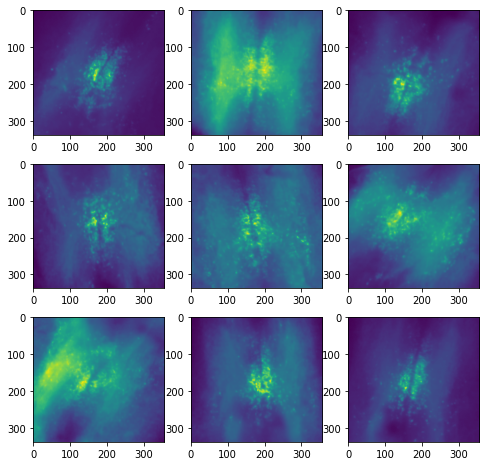

<Figure size 432x288 with 0 Axes>

In [105]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3


for i in range(1, columns*rows+1):
    img = t_dd[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

plt.savefig('/media/renata/renata_data_2/Figures_Ablation/sum_rois/vTel/dDMSO/t_dd.png', bbox_inches='tight')

### Background subtraction

In [107]:
def bg_subs(roi_group, bg_group):
    
    rois_wo_bg = []
    
    for roi, bg in zip(roi_group, bg_group):
        
        roi_wo_bg = roi/np.mean(bg)
        rois_wo_bg.append(roi_wo_bg)
    
    return rois_wo_bg

#### vTel

The signal is more distict but there is still a lot of background in the images, specially in the treated group (mtz). Therefore, I will take a small piece of bg (30x30), compute the mean, and devide the image to the result value.

In [ ]:
bg_t_dd_1 = lg_t_dd[0][70:100,100:130] 
bg_t_dd_2 = lg_t_dd[1][30:60,70:100] 
bg_t_dd_3 = lg_t_dd[2][230:260,250:280]
bg_t_dd_4 = lg_t_dd[3][280:310,260:290]
bg_t_dd_5 = lg_t_dd[4][95:125,70:100]
bg_t_dd_6 = lg_t_dd[5][30:60,280:310]
bg_t_dd_7 = lg_t_dd[6][270:300,300:330]
bg_t_dd_8 = lg_t_dd[7][75:105,280:310]
bg_t_dd_9 = lg_t_dd[8][100:130,280:310]

bg_t_dv_1 = lg_t_dv[0][10:40,190:220]
bg_t_dv_2 = lg_t_dv[1][70:100,230:260]
bg_t_dv_3 = lg_t_dv[2][250:280,100:130]
bg_t_dv_4 = lg_t_dv[3][120:150,50:80]
bg_t_dv_5 = lg_t_dv[4][115:145,290:320]
bg_t_dv_6 = lg_t_dv[5][290:320,180:210]
bg_t_dv_7 = lg_t_dv[6][270:300,120:150]
bg_t_dv_8 = lg_t_dv[7][70:100,60:90]
bg_t_dv_9 = lg_t_dv[8][180:210,70:100]


bg_t_md_1 = lg_t_md[0][230:260,310:340]
bg_t_md_2 = lg_t_md[1][30:65,25:60]
bg_t_md_3 = lg_t_md[2][210:240,60:90]
bg_t_md_4 = lg_t_md[3][280:310,290:320]
bg_t_md_5 = lg_t_md[4][240:270,310:340]
bg_t_md_6 = lg_t_md[5][160:190,280:320]
bg_t_md_7 = lg_t_md[6][140:170,50:80]
bg_t_md_8 = lg_t_md[7][170:200,120:150]
bg_t_md_9 = lg_t_md[8][270:300,80:110]


bg_t_mv_1 = lg_t_mv[0][300:330,280:310]
bg_t_mv_2 = lg_t_mv[1][180:210,60:90]
bg_t_mv_3 = lg_t_mv[2][220:250,60:90]
bg_t_mv_4 = lg_t_mv[3][120:150,75:105]
bg_t_mv_5 = lg_t_mv[4][290:320,100:130]
bg_t_mv_6 = lg_t_mv[5][130:160,50:80]
bg_t_mv_7 = lg_t_mv[6][100:130,60:90]
bg_t_mv_8 = lg_t_mv[7][50:80,260:290]
bg_t_mv_9 = lg_t_mv[8][230:260,250:280]



bg_t_dd = [bg_t_dd_1,bg_t_dd_2,bg_t_dd_3,bg_t_dd_4,bg_t_dd_5,bg_t_dd_6,bg_t_dd_7,bg_t_dd_8,bg_t_dd_9]
bg_t_dv = [bg_t_dv_1,bg_t_dv_2,bg_t_dv_3,bg_t_dv_4,bg_t_dv_5,bg_t_dv_6,bg_t_dv_7,bg_t_dv_8,bg_t_dv_9]
bg_t_md = [bg_t_md_1,bg_t_md_2,bg_t_md_3,bg_t_md_4,bg_t_md_5,bg_t_md_6,bg_t_md_7,bg_t_md_8,bg_t_md_9]
bg_t_mv = [bg_t_mv_1,bg_t_mv_2,bg_t_mv_3,bg_t_mv_4,bg_t_mv_5,bg_t_mv_6,bg_t_mv_7,bg_t_mv_8,bg_t_mv_9]

In [ ]:
t_dd = bg_subs(lg_t_dd, bg_t_dd)
t_dv = bg_subs(lg_t_dv, bg_t_dv)
t_md = bg_subs(lg_t_md, bg_t_md)
t_mv = bg_subs(lg_t_mv, bg_t_mv)

In [ ]:
# Example for the positive control for the vTel roi, dorsal side 

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3


for i in range(1, columns*rows+1):
    img = t_dd[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)poa

plt.show()

#### POA

The signal is more distict but there is still a lot of background in the images, specially in the treated group (mtz). Therefore, I will take a small piece of bg (15x15), compute the mean, and devide the image to the result value.

In [ ]:
bg_d_dd_1 = lg_d_dd[0][150:165,120:135] 
bg_d_dd_2 = lg_d_dd[1][125:140,140:155] 
bg_d_dd_3 = lg_d_dd[2][140:155,130:145]
bg_d_dd_4 = lg_d_dd[3][95:110,140:155]
bg_d_dd_5 = lg_d_dd[4][125:140,130:145]
bg_d_dd_6 = lg_d_dd[5][55:70,45:60]
bg_d_dd_7 = lg_d_dd[6][40:55,45:60]
bg_d_dd_8 = lg_d_dd[7][145:160,135:150]
bg_d_dd_9 = lg_d_dd[8][120:135,15:30]

bg_d_dv_1 = lg_d_dv[0][60:75,140:155]
bg_d_dv_2 = lg_d_dv[1][85:100,20:35]
bg_d_dv_3 = lg_d_dv[2][125:140,35:50]
bg_d_dv_4 = lg_d_dv[3][160:175,120:135]
bg_d_dv_5 = lg_d_dv[4][155:170,30:45]
bg_d_dv_6 = lg_d_dv[5][155:170,60]
bg_d_dv_7 = lg_d_dv[6][90:105,115:130]
bg_d_dv_8 = lg_d_dv[7][140:155,20:35]
bg_d_dv_9 = lg_d_dv[8][170:185,25:40]


bg_d_md_1 = lg_d_md[0][50:65,120:135]
bg_d_md_2 = lg_d_md[1][150:615,120:135]
bg_d_md_3 = lg_d_md[2][160:175,50:65]
bg_d_md_4 = lg_d_md[3][80:95,130:145]
bg_d_md_5 = lg_d_md[4][160:175,25:40]
bg_d_md_6 = lg_d_md[5][165:180,105:120]
bg_d_md_7 = lg_d_md[6][120:135,25:40]
bg_d_md_8 = lg_d_md[7][30:45,70:85]
bg_d_md_9 = lg_d_md[8][95:110,20:35]


bg_d_mv_1 = lg_d_mv[0][40:55,115:130]
bg_d_mv_2 = lg_d_mv[1][95:110,30:45]
bg_d_mv_3 = lg_d_mv[2][85:100,135:150]
bg_d_mv_4 = lg_d_mv[3][65:80,30:45]
bg_d_mv_5 = lg_d_mv[4][145:160,110:125]
bg_d_mv_6 = lg_d_mv[5][40:55,110:125]
bg_d_mv_7 = lg_d_mv[6][120:135,135:150]
bg_d_mv_8 = lg_d_mv[7][160:175,20:35]
bg_d_mv_9 = lg_d_mv[8][165:180,120:135]




bg_d_dd = [bg_d_dd_1,bg_d_dd_2,bg_d_dd_3,bg_d_dd_4,bg_d_dd_5,bg_d_dd_6,bg_d_dd_7,bg_d_dd_8,bg_d_dd_9]
bg_d_dv = [bg_d_dv_1,bg_d_dv_2,bg_d_dv_3,bg_d_dv_4,bg_d_dv_5,bg_d_dv_6,bg_d_dv_7,bg_d_dv_8,bg_d_dv_9]
bg_d_md = [bg_d_md_1,bg_d_md_2,bg_d_md_3,bg_d_md_4,bg_d_md_5,bg_d_md_6,bg_d_md_7,bg_d_md_8,bg_d_md_9]
bg_d_mv = [bg_d_mv_1,bg_d_mv_2,bg_d_mv_3,bg_d_mv_4,bg_d_mv_5,bg_d_mv_6,bg_d_mv_7,bg_d_mv_8,bg_d_mv_9]

In [ ]:
d_dd = bg_subs(lg_d_dd, bg_d_dd)
d_dv = bg_subs(lg_d_dv, bg_d_dv)
d_md = bg_subs(lg_d_md, bg_d_md)
d_mv = bg_subs(lg_d_mv, bg_d_mv)

In [ ]:
# Example for the positive control for the vTel roi, dorsal side 

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3


for i in range(1, columns*rows+1):
    img = d_dd[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()